<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/NN_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**

In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

In [3]:
import torchmetrics
import torchvision

In [4]:
from torch import nn
from torch.nn import functional as F

In [5]:
import time 

In [6]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

In [8]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [10]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [11]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define MultiLayer Neural Network**

In [12]:
class MNN(nn.Module):
  def __init__(self, input_size, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
    super().__init__()

    self.w1 = nn.Parameter(fc1w)
    self.b1 = nn.Parameter(fc1b)
    
    self.w2 = nn.Parameter(fc2w)
    self.b2 = nn.Parameter(fc2b)

    self.w3 = nn.Parameter(fc3w)
    self.b3 = nn.Parameter(fc3b)

  def forward(self, x):
    x = F.relu(x@self.w1 + self.b1)
    x = F.relu(x@self.w2 + self.b2)
    x = x@self.w3 + self.b3
    x = x.reshape(1, -1)

    return torch.softmax(x, 1)

In [13]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Initialize the parameters**

In [14]:
# We initialize the parameters randomly with values in [-1, 1] and the model with an input size
fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1)
fc1b = torch.FloatTensor(64).uniform_(-1, 1)
fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1)
fc2b = torch.FloatTensor(8).uniform_(-1, 1)
fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1)
fc3b = torch.FloatTensor(3).uniform_(-1, 1)
mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)

In [15]:
# We try our model with the first example
print(mnn(Xtrain[0].to(device)))

tensor([[0.0563, 0.0029, 0.9408]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [16]:
def pred(x, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j]
    xj = F.relu(xj@fc1w + fc1b)
    xj = F.relu(xj@fc2w + fc2b)
    xj = xj@fc3w + fc3b
    xj = xj.reshape(1, -1)
    ypred[j]=torch.softmax(xj, 1)
  return ypred

In [17]:
ypred = pred(Xtrain, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b)

# **Define accuracy**

In [18]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [19]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device), ypred.to(device))

tensor(0.0680, device='cuda:0')

# **Define Cross-Entropy**

In [20]:
def cross_entropy(ytrue, ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
# Cross_entropy at initialization
print(cross_entropy(ytrain.to(device), ypred.to(device)))

tensor(2.9636, device='cuda:0')


Define error

In [22]:
def error(ytrue, model, x):
  error=0
  for i in range (ytrue.size(0)):
    ypredi = model(x[i])
    if (ypredi.argmax(1)- ytrue[i])!=0:
      error = error+ 1
  return error

# **Train and evaluate the network**

In [26]:
def train_bwd_gradient(x, y):
  x, y = x.to(device), y.to(device)

  losses = [] #Vector with the cross_entropy values of the test set
  accuracies = [] #Vector with the accuracy values of the test set
  errors = [] #Vector with the number of misclassifications of the test set

  l_rate0 = 0.05 #Learning rate used

  #Initialize the parameters
  fc1w = torch.FloatTensor(4, 64).uniform_(-1, 1).requires_grad_(True)
  fc1b = torch.FloatTensor(64).uniform_(-1, 1).requires_grad_(True)
  fc2w = torch.FloatTensor(64, 8).uniform_(-1, 1).requires_grad_(True)
  fc2b = torch.FloatTensor(8).uniform_(-1, 1).requires_grad_(True)
  fc3w = torch.FloatTensor(8, 3).uniform_(-1, 1).requires_grad_(True)
  fc3b = torch.FloatTensor(3).uniform_(-1, 1).requires_grad_(True)

  ypred = pred(x, fc1w.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device))
  ypred = ypred.to(device)
  loss = cross_entropy(y, ypred) # Loss function

  t = 0
  t0 = time.time()

  while loss>0.2:

    #Compute the gradients
    loss.backward()

    with torch.no_grad():

      #Apply gradients
      fc1w -= l_rate0*fc1w.grad
      fc1b -= l_rate0*fc1b.grad
      fc2w -= l_rate0*fc2w.grad
      fc2b -= l_rate0*fc2b.grad
      fc3w -= l_rate0*fc3w.grad
      fc3b -= l_rate0*fc3b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration
      fc1w.grad.zero_()
      fc1b.grad.zero_()
      fc2w.grad.zero_()
      fc2b.grad.zero_()
      fc3w.grad.zero_()
      fc3b.grad.zero_()


    # We calculate the number of the misclassfications of the test set with the updated model and we add it to the errors vector
    mnn = MNN(4, fc1w, fc1b, fc2w, fc2b, fc3w, fc3b).to(device)
    ypredT = pred(Xtest.to(device), fc1w.to(device), fc1b.to(device), fc2w.to(device), fc2b.to(device), fc3w.to(device), fc3b.to(device))
    ypredT = ypredT.to(device)
    errors.append(error(ytest.to(device), mnn, Xtest.to(device)))

    # We calculate the cross_entropy of the test set with the updated model and we add it to the losses vector
    loss = cross_entropy(ytest.to(device), ypredT)
    losses.append(loss.cpu())

    # We calculate the accuracy of the test set with the updated model and we add it to the accuracies vector
    accuracies.append(accuracy(ytest.to(device), ypredT).item())

    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)

  return fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors

In [27]:
fc1w, fc1b, fc2w, fc2b, fc3w, fc3b, losses, accuracies, errors = train_bwd_gradient(Xtrain, ytrain)

Time 0.11423301696777344 loss tensor(1.2354, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.20000624656677246 loss tensor(1.0716, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.27994751930236816 loss tensor(0.9258, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.34977197647094727 loss tensor(0.8232, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.41924238204956055 loss tensor(0.7516, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.4854748249053955 loss tensor(0.7205, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.5522201061248779 loss tensor(0.6719, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.62046217918396 loss tensor(0.6415, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.6857097148895264 loss tensor(0.6038, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.7630777359008789 loss tensor(0.5782, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.8304283618927002 loss tensor(0.5518, device='cuda:0', grad_fn=<NegBackward0>)
Time 0.8917050361633301 loss tensor(0.5315, device='cuda:0', g

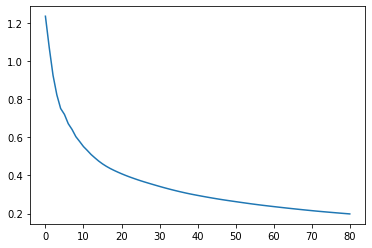

In [28]:
with torch.no_grad():
  plt.plot(losses)

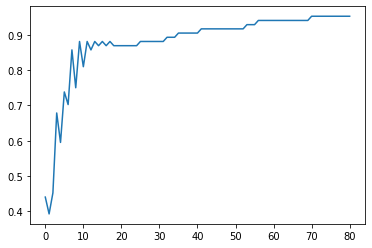

In [29]:
plt.plot(accuracies)

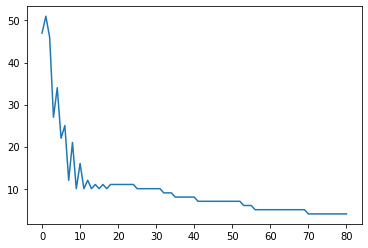

In [30]:
plt.plot(errors)